### Import libraries

In [51]:
import pandas as pd 
import numpy as np
import pickle
from sklearn import svm
from sklearn import metrics
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, matthews_corrcoef
from tensorflow.keras.preprocessing.sequence import pad_sequences



dataset = pd.read_csv('supData1_full.csv', sep=',', header=0, index_col=0)

### Import data and visualize it's structure

In [4]:
# verify the shape of the dataset
print(dataset.shape)
dataset.head()


(21154, 3)


,sequence,bio_category,label
0,MKFLLVAALCALVAIGSCKPTREEIKTFEQFKKVFGKVYRNAEEEA...,oribatida,1
1,EIASQIAQEDQSTCEVSKGDFKTFDRMSFTCSFNKSCNVVVAQDCT...,gallus gallus,1
2,MSWQTYVDDHLMCEIEGNYLTSAAIIGQDGSIWAQSASFPQFKPEE...,actinidia deliciosa,1
3,MKCLLLALALTCGAQALIVTQTMKGLDIQKVAGTWYSLAMAASDIS...,bos taurus,1
4,MWFLALCLAMSLGWTGAEPHFQPRIIGGRECLKNSQPWQVAVYHNG...,carnivora,1


In [4]:
# check the distribution of the labels
dataset['label'].value_counts()

label
-1    18906
 1     2248
Name: count, dtype: int64

In [5]:
# Check the length of the longest sequence
for column in dataset:
    print(column, dataset[column].astype(str).str.len().max())

sequence 34350
bio_category 34
label 2


In [6]:
# Remove sequences with length >= 500
df = dataset[dataset['sequence'].str.len() <= 500]

In [7]:
# Check the length of the longest sequence after removing sequences with length >= 500
for column in df:
    print(column, df[column].astype(str).str.len().max())

sequence 500
bio_category 34
label 2


In [8]:
# Check how many sequences are left
len(df)

15457

In [12]:
# Convert the labels to binary values in wich -1 is converted to 0 for the orignal dataset
dataset.loc[dataset['label']== -1, 'label'] = 0

In [9]:
# Convert the labels to binary values in wich -1 is converted to 0 for the dataset with sequences with length <= 500
df.loc[df['label'] == -1, 'label'] = 0

In [13]:
# value count of labels before removing sequences with length > 500
dataset['label'].value_counts()

label
0    18906
1     2248
Name: count, dtype: int64

In [12]:
# See the balance of the dataset labels after removing the sequences with length > 500
df['label'].value_counts()

label
0    13386
1     2071
Name: count, dtype: int64

In [11]:
# Confirm that the features and labels are of the same length
print(len(df['sequence']))
print(len(df['label']))

15457
15457


In [12]:
# Convert dataframe into a csv file 
df.to_csv('prot_allergy_500.csv', sep=',', header=True, index=True)

#### For this pipeline it was used the df dataset

In [29]:
# Load the dataset with sequecenes of length 500aa
df = pd.read_csv('prot_allergy_500.csv', sep=',', header=0, index_col=0)

### One-hot encode protein sequences

In [30]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Function to one-hot encode the sequences
def one_hot_encode(sequences):
    amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'X', 'U', 'B', 'Z', 'O']
    
    encoded_sequences = []
    
    for sequence in sequences:
        encoded_sequence = []
        for amino_acid in sequence:
            vector = [0] * len(amino_acids)
            if amino_acid in amino_acids:
                vector[amino_acids.index(amino_acid)] = 1
            encoded_sequence.append(vector)
        encoded_sequences.append(encoded_sequence)
    
    padded_sequences = pad_sequences(encoded_sequences, padding='post', dtype='float32')
    
    return padded_sequences

In [31]:
#Function to get the protein sequences as a list
protein_sequences = list(df['sequence'].values)
type(protein_sequences[0])

str

In [32]:
# One-hot encode the sequences
encoded_sequences = one_hot_encode(protein_sequences)

In [33]:
# flatten the sequences
flattened_sequences = encoded_sequences.reshape(encoded_sequences.shape[0], -1)
print(flattened_sequences)
print(len(flattened_sequences[0]))
print(sum(flattened_sequences[0]))
flattened_sequences.shape

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
12500
333.0


(15457, 12500)

In [34]:
len(flattened_sequences)

15457

In [35]:
#labels as y
labels= df['label'].values

len(labels)

15457

### Split data into training and testing sets

In [36]:
print("Allergenic proteins:", sum(labels==1))
print("Non allergenic proteins:", sum(labels==0))

# Split the dataset into train and test sets, apply stratification to ensure equal weights of classes in train and test sets
X_train, X_test, y_train, y_test = train_test_split(flattened_sequences, labels, test_size=0.20, random_state=42, stratify=labels)

print('Y_train 1:', sum(y_train==1))
print('Y_train 0:', sum(y_train==0))
print('Y_test 1:', sum(y_test==1))
print('Y_test 0:', sum(y_test==0))



Allergenic proteins: 2071
Non allergenic proteins: 13386
Y_train 1: 1657
Y_train 0: 10708
Y_test 1: 414
Y_test 0: 2678


### SVM model training and predictions

In [37]:
clf = svm.SVC(class_weight='balanced')   #Não corri este porque ia demorar muito tempo, mas balanceia o dataset
#clf = svm.SVC()
clf.fit(X_train, y_train)

SVC(class_weight='balanced')

In [38]:
predictions = clf.predict(X_test)

In [55]:
print(classification_report(y_test, predictions))
MCCSVM = matthews_corrcoef(y_test, predictions)
print("MCC SVM:", MCCSVM)

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      2678
           1       0.77      0.76      0.77       414

    accuracy                           0.94      3092
   macro avg       0.87      0.86      0.87      3092
weighted avg       0.94      0.94      0.94      3092

MCC SVM: 0.7334500744188931


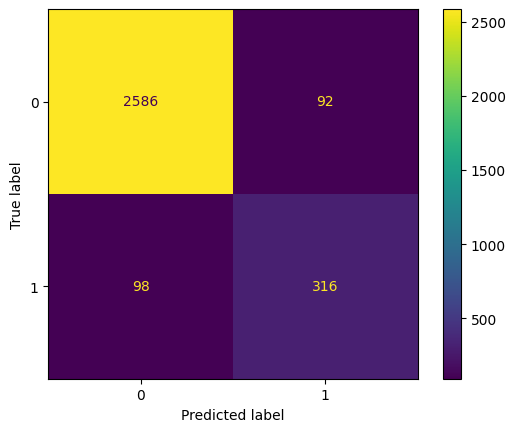

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

disp_svm = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, predictions))
disp_svm.plot()

### LINEAR SVM

In [41]:
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, make_scorer

param_grid = {'C': [0.1, 1, 10, 100],
              'class_weight': ['balanced', None]}

scorer = make_scorer(f1_score, pos_label=1)

lsvm = GridSearchCV(LinearSVC(class_weight='balanced'), param_grid=param_grid, verbose=3, cv=5, scoring=scorer)
lsvm.fit(X_train, y_train)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END ......C=0.1, class_weight=balanced;, score=0.769 total time=   3.3s
[CV 2/5] END ......C=0.1, class_weight=balanced;, score=0.732 total time=   3.6s
[CV 3/5] END ......C=0.1, class_weight=balanced;, score=0.730 total time=   3.1s
[CV 4/5] END ......C=0.1, class_weight=balanced;, score=0.758 total time=   3.6s
[CV 5/5] END ......C=0.1, class_weight=balanced;, score=0.733 total time=   3.7s
[CV 1/5] END ..........C=0.1, class_weight=None;, score=0.768 total time=   2.6s
[CV 2/5] END ..........C=0.1, class_weight=None;, score=0.728 total time=   2.7s
[CV 3/5] END ..........C=0.1, class_weight=None;, score=0.725 total time=   2.6s
[CV 4/5] END ..........C=0.1, class_weight=None;, score=0.752 total time=   2.5s
[CV 5/5] END ..........C=0.1, class_weight=None;, score=0.728 total time=   2.8s


/home/rfernandes/miniconda3/envs/projeto/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END ........C=1, class_weight=balanced;, score=0.746 total time=   3.7s


/home/rfernandes/miniconda3/envs/projeto/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END ........C=1, class_weight=balanced;, score=0.681 total time=   3.7s


/home/rfernandes/miniconda3/envs/projeto/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END ........C=1, class_weight=balanced;, score=0.693 total time=   3.7s


/home/rfernandes/miniconda3/envs/projeto/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END ........C=1, class_weight=balanced;, score=0.697 total time=   3.7s


/home/rfernandes/miniconda3/envs/projeto/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END ........C=1, class_weight=balanced;, score=0.684 total time=   3.7s


/home/rfernandes/miniconda3/envs/projeto/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END ............C=1, class_weight=None;, score=0.751 total time=   3.7s


/home/rfernandes/miniconda3/envs/projeto/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END ............C=1, class_weight=None;, score=0.677 total time=   3.6s


/home/rfernandes/miniconda3/envs/projeto/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END ............C=1, class_weight=None;, score=0.691 total time=   3.8s


/home/rfernandes/miniconda3/envs/projeto/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END ............C=1, class_weight=None;, score=0.706 total time=   3.6s


/home/rfernandes/miniconda3/envs/projeto/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END ............C=1, class_weight=None;, score=0.678 total time=   3.7s


/home/rfernandes/miniconda3/envs/projeto/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END .......C=10, class_weight=balanced;, score=0.735 total time=   3.7s


/home/rfernandes/miniconda3/envs/projeto/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END .......C=10, class_weight=balanced;, score=0.670 total time=   3.6s


/home/rfernandes/miniconda3/envs/projeto/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END .......C=10, class_weight=balanced;, score=0.676 total time=   3.6s


/home/rfernandes/miniconda3/envs/projeto/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END .......C=10, class_weight=balanced;, score=0.682 total time=   3.6s


/home/rfernandes/miniconda3/envs/projeto/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END .......C=10, class_weight=balanced;, score=0.671 total time=   3.6s


/home/rfernandes/miniconda3/envs/projeto/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END ...........C=10, class_weight=None;, score=0.733 total time=   3.6s


/home/rfernandes/miniconda3/envs/projeto/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END ...........C=10, class_weight=None;, score=0.670 total time=   3.6s


/home/rfernandes/miniconda3/envs/projeto/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END ...........C=10, class_weight=None;, score=0.675 total time=   3.7s


/home/rfernandes/miniconda3/envs/projeto/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END ...........C=10, class_weight=None;, score=0.682 total time=   3.6s


/home/rfernandes/miniconda3/envs/projeto/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END ...........C=10, class_weight=None;, score=0.673 total time=   3.6s


/home/rfernandes/miniconda3/envs/projeto/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END ......C=100, class_weight=balanced;, score=0.734 total time=   3.7s


/home/rfernandes/miniconda3/envs/projeto/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END ......C=100, class_weight=balanced;, score=0.671 total time=   3.6s


/home/rfernandes/miniconda3/envs/projeto/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END ......C=100, class_weight=balanced;, score=0.675 total time=   3.7s


/home/rfernandes/miniconda3/envs/projeto/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END ......C=100, class_weight=balanced;, score=0.678 total time=   3.6s


/home/rfernandes/miniconda3/envs/projeto/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END ......C=100, class_weight=balanced;, score=0.669 total time=   3.6s


/home/rfernandes/miniconda3/envs/projeto/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END ..........C=100, class_weight=None;, score=0.733 total time=   3.7s


/home/rfernandes/miniconda3/envs/projeto/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END ..........C=100, class_weight=None;, score=0.669 total time=   3.6s


/home/rfernandes/miniconda3/envs/projeto/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END ..........C=100, class_weight=None;, score=0.676 total time=   3.7s


/home/rfernandes/miniconda3/envs/projeto/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END ..........C=100, class_weight=None;, score=0.678 total time=   3.6s


/home/rfernandes/miniconda3/envs/projeto/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END ..........C=100, class_weight=None;, score=0.671 total time=   3.7s


GridSearchCV(cv=5, estimator=LinearSVC(class_weight='balanced'),
             param_grid={'C': [0.1, 1, 10, 100],
                         'class_weight': ['balanced', None]},
             scoring=make_scorer(f1_score, pos_label=1), verbose=3)

In [42]:
lsvm_pred = lsvm.predict(X_test)

In [53]:
print(classification_report(y_test, lsvm_pred))
MCC = matthews_corrcoef(y_test, lsvm_pred)
print("MCC:" , MCC)

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      2678
           1       0.68      0.77      0.72       414

    accuracy                           0.92      3092
   macro avg       0.82      0.85      0.84      3092
weighted avg       0.92      0.92      0.92      3092

MCC: 0.6739688633679511


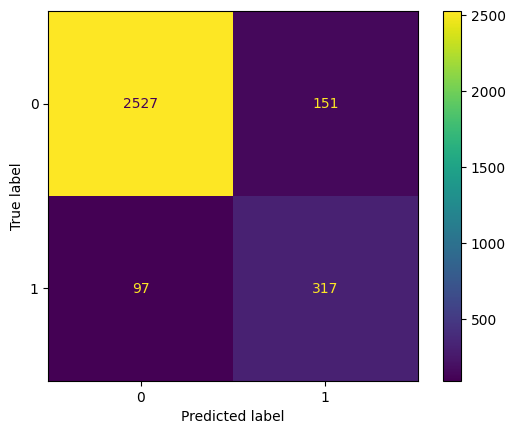

In [44]:
disp_lsvm = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, lsvm_pred))
disp_lsvm.plot()

In [45]:
print(lsvm.best_params_)

{'C': 0.1, 'class_weight': 'balanced'}


### Logistic Regression

In [46]:
from sklearn.linear_model import LogisticRegression

param_grid = {'C': [0.5, 1, 10, 100],
              'class_weight': ['balanced', None],
            }   

scorer = make_scorer(f1_score, pos_label = 1)

grid_lr = GridSearchCV(LogisticRegression(max_iter=10000),param_grid, verbose=3, cv=5, scoring=scorer)
grid_lr.fit(X_train, y_train)
y_pred_grid_lr = grid_lr.predict(X_test)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END ......C=0.5, class_weight=balanced;, score=0.777 total time=   3.7s
[CV 2/5] END ......C=0.5, class_weight=balanced;, score=0.764 total time=   3.7s
[CV 3/5] END ......C=0.5, class_weight=balanced;, score=0.757 total time=   4.0s
[CV 4/5] END ......C=0.5, class_weight=balanced;, score=0.789 total time=   3.6s
[CV 5/5] END ......C=0.5, class_weight=balanced;, score=0.765 total time=   4.1s
[CV 1/5] END ..........C=0.5, class_weight=None;, score=0.795 total time=   4.0s
[CV 2/5] END ..........C=0.5, class_weight=None;, score=0.766 total time=   3.8s
[CV 3/5] END ..........C=0.5, class_weight=None;, score=0.750 total time=   4.0s
[CV 4/5] END ..........C=0.5, class_weight=None;, score=0.794 total time=   4.1s
[CV 5/5] END ..........C=0.5, class_weight=None;, score=0.777 total time=   4.2s
[CV 1/5] END ........C=1, class_weight=balanced;, score=0.767 total time=   4.3s
[CV 2/5] END ........C=1, class_weight=balanced;,

In [54]:
print(classification_report(y_test, y_pred_grid_lr))
MCCLG = matthews_corrcoef(y_test, y_pred_grid_lr)
print("MCC:" , MCCLG)

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      2678
           1       0.80      0.71      0.75       414

    accuracy                           0.94      3092
   macro avg       0.88      0.84      0.86      3092
weighted avg       0.94      0.94      0.94      3092

MCC: 0.7199327352781902


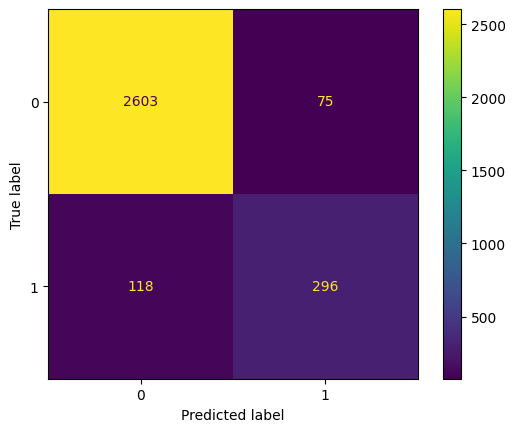

In [48]:
disp_lsvm = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_grid_lr))
disp_lsvm.plot()

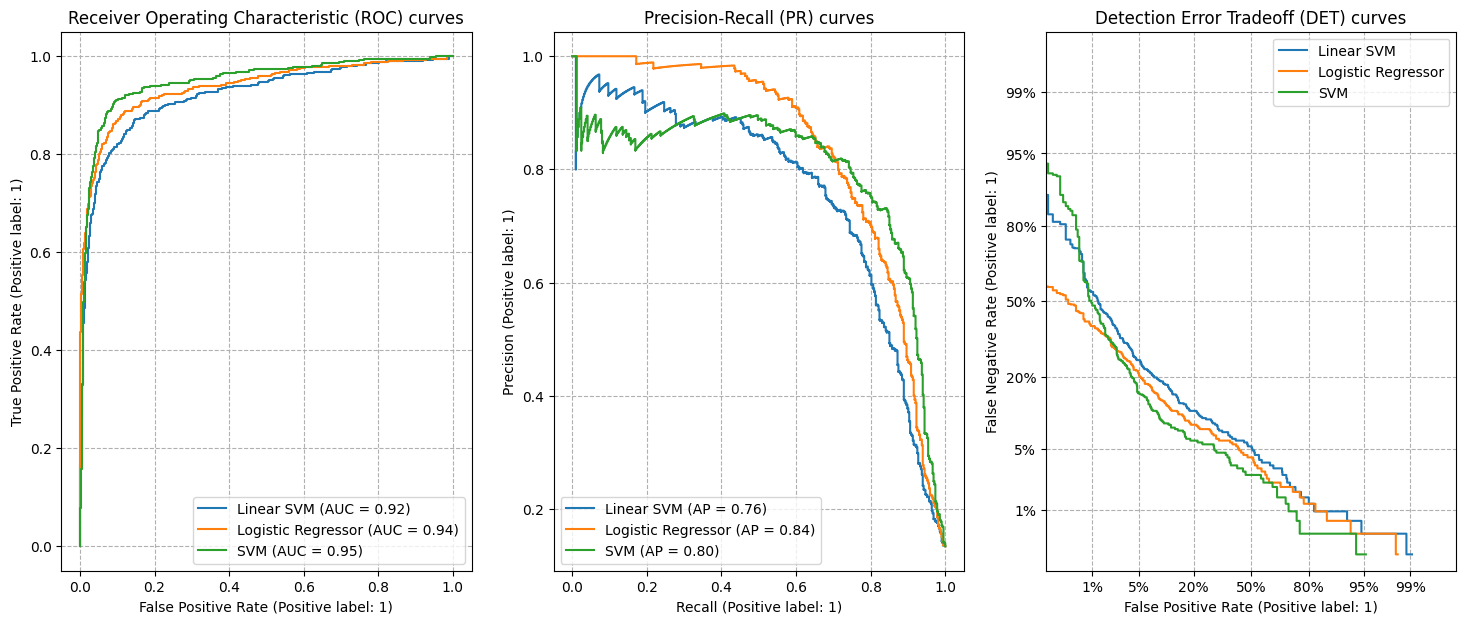

In [49]:

classifiers = {
    "Linear SVM": lsvm.best_estimator_,
    "Logistic Regressor": grid_lr.best_estimator_,
    'SVM': clf,
    
}

import matplotlib.pyplot as plt
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay, PrecisionRecallDisplay

fig, [ax_roc, ax_pr, ax_det] = plt.subplots(1, 3, figsize=(18, 7))

for name, classif in classifiers.items():
    classif.fit(X_train, y_train)

    RocCurveDisplay.from_estimator(classif, X_test, y_test, ax=ax_roc, name=name)
    PrecisionRecallDisplay.from_estimator(classif, X_test, y_test, ax=ax_pr, name=name)
    DetCurveDisplay.from_estimator(classif, X_test, y_test, ax=ax_det, name=name)

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_pr.set_title("Precision-Recall (PR) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_pr.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
plt.show()